# **FOOD CLASSIFICATION**


* This is a computer vision project to create food classification. The dataset used is Food 101. Only a portion of the dataset is taken, namely pizza, steak, and sushi. This project uses the pretrained ResNet 50 model.

* In addition to creating a classification model, this project also aims to compare two types of transfer learning methods, namely fine-tuning and fix feature extractor. Fine-tuning involves retraining all parameters of the pretrained model on a different dataset to adjust its weights. Fix feature extractor only trains the modified fully connected layer, while other parameters are not trained again.

* Based on existing theories, the fine-tuning method may cause overfitting because all parameters are retrained. This also results in longer training processes. To address this overfitting, it may be necessary to modify some layers, including the fully connected layer. The fix feature extractor method is considered more practical, simple, and easy to use because only the fully connected layer is modified and trained, thus avoiding overfitting.

* The results of this comparison have been demonstrated in this experimental documentation.

## **0. Getting Setup**



In [ ]:
# import dependencies
import torch
import torchvision
import time
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import Adam, SGD
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
from pathlib import Path
from typing import Dict, List

In [ ]:
# try to get torch info, install it if it doesn't work
try:
  from torchinfo import summary
  print("[INFO] torchinfo imported successfully.")
except:
  print("[INFO] Couldn't find torchinfo. Installing it.")
  !pip install -q torchinfo
  from torchinfo import summary
  print("[INFO] torchinfo installed and imported successfully.")

[INFO] Couldn't find torchinfo. Installing it.
[INFO] torchinfo installed and imported successfully.


In [ ]:
# setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# setting fix hyperparameter
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

## **1. Get Data and Exploratory Data Analysis**

### a. Setting dataset directory

In [ ]:
# access the dataset directory
image_dir = Path("/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/Food Dataset")

print(image_dir)

/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/Food Dataset


In [ ]:
# access train and validation directory
train_dir = image_dir / "train"
val_dir = image_dir / "val"

print(train_dir)
print(val_dir)

/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/Food Dataset/train
/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/Food Dataset/val


In [ ]:
# dataset classes
print("Train Data Classes: ", sorted(os.listdir(train_dir)))
print("Validation Data Classes: ", sorted(os.listdir(val_dir)))

Train Data Classes:  ['pizza', 'steak', 'sushi']
Validation Data Classes:  ['pizza', 'steak', 'sushi']


### b. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) aims to understand the characteristics, contents, and distributions of a dataset, as well as to clean it so that it is ready for use in machine learning or deep learning modeling. In this project, the dataset is already clean and has been separated into training and validation data. From this EDA, we have obtained information including:

1. All images have the ".jpg" extension. It is preferable that the image extension is indeed ".jpg" because its size is smaller compared to other extensions, thus reducing computational burden.
2. All images are RGB but have various sizes (there are 28 different image sizes). This is not a problem because later the image sizes will be standardized during the data preprocessing stage.
3. The distribution of training data is relatively balanced, but the distribution of validation data is imbalanced. Additionally, the amount of data can be considered very small. This can result in poor model performance. In this project, soft augmentation processes are performed to enrich the data variations, thus improving the model's performance.

In [ ]:
# check the data extension
def check_file_extensions(path):
    extensions = set()
    for root, dirs, files in os.walk(path):
        for file in files:
            file_ext = os.path.splitext(file)[-1].lower()
            extensions.add(file_ext)
    return extensions

file_extensions = check_file_extensions(image_dir)
print("File Extensions in the Dataset: ", file_extensions)

File Extensions in the Dataset:  {'.jpg'}


In [ ]:
# check the dataset shape
def check_data_shapes(path):
    data_shapes = set()
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            data_shapes.add(img.shape)
    return data_shapes

data_shape = check_data_shapes(image_dir)
print("File Shapes in the Dataset: ", data_shape)
print("Number of Shape Types in the Dataset: ", len(data_shape))

File Shapes in the Dataset:  {(511, 512, 3), (342, 512, 3), (408, 512, 3), (383, 512, 3), (343, 512, 3), (512, 306, 3), (366, 512, 3), (344, 512, 3), (382, 512, 3), (333, 512, 3), (295, 512, 3), (512, 341, 3), (512, 442, 3), (512, 508, 3), (341, 512, 3), (307, 512, 3), (512, 512, 3), (512, 382, 3), (484, 512, 3), (287, 512, 3), (288, 512, 3), (339, 512, 3), (384, 512, 3), (512, 384, 3), (289, 512, 3), (512, 289, 3), (512, 511, 3), (262, 512, 3)}
Number of Shape Types in the Dataset:  28


In [ ]:
# display data distribution
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

# calculate total data of each class
train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

# create dataframe class count
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

print("Dataframe Train Data: \n", train_counts_df)
print("\nDataframe Validation Data: \n", val_counts_df)

Dataframe Train Data: 
        Count
pizza     78
steak     75
sushi     72

Dataframe Validation Data: 
        Count
pizza     25
steak     19
sushi     31


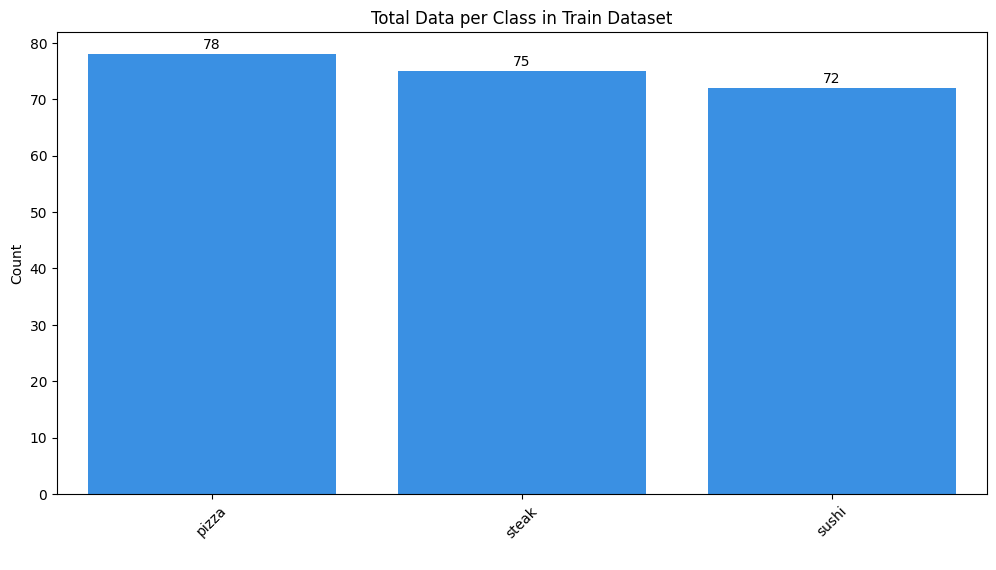

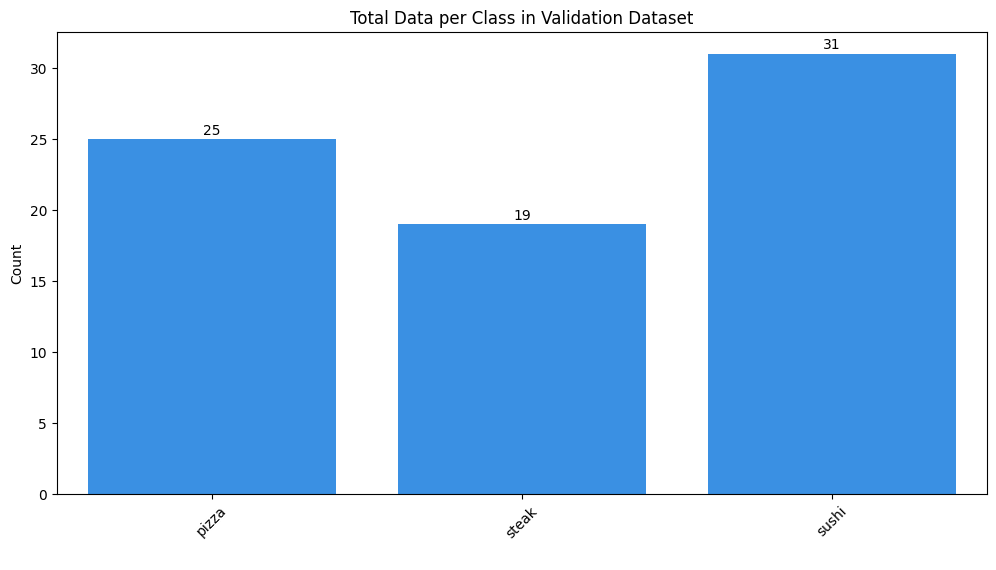

In [ ]:
# display countplot for train data
plt.figure(figsize=(12, 6))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="dodgerblue")
plt.title("Total Data per Class in Train Dataset")
plt.xlabel(" ")
plt.ylabel("Count")
plt.xticks(rotation=45)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+1, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

plt.show()

# display countplot for validation data
plt.figure(figsize=(12, 6))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="dodgerblue")
plt.title("Total Data per Class in Validation Dataset")
plt.xlabel(" ")
plt.ylabel("Count")
plt.xticks(rotation=45)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+0.35, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

plt.show()

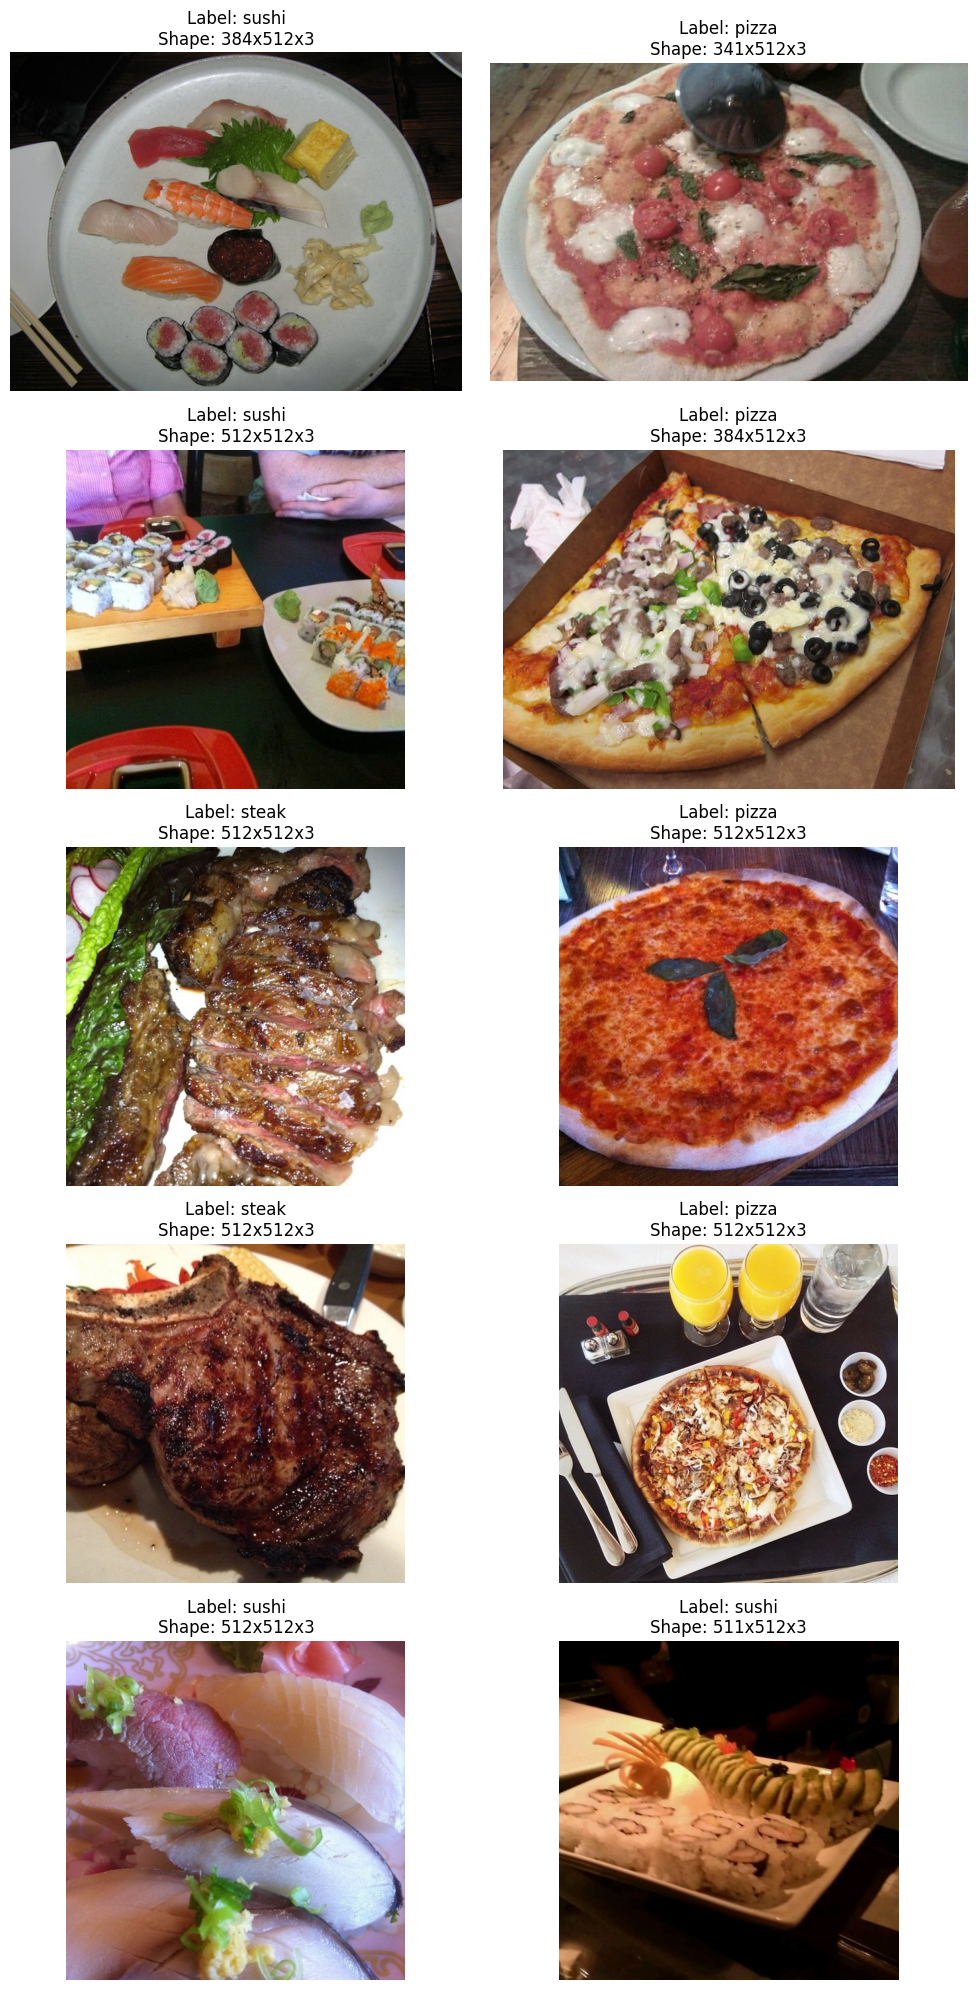

In [ ]:
# get all of the image paths
image_path_list = list(image_dir.glob("*/*/*.jpg"))

# choose 10 image paths randomly
random_image_paths = random.sample(image_path_list, 10)

# define the subplot
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

# display 10 images randomly
for i, ax in enumerate(axes.flat):
    # get image path
    random_image_path = random_image_paths[i]
    # get image label from path name
    image_class = random_image_path.parent.stem
    # open image
    img = Image.open(random_image_path)
    # display image on subplot
    ax.imshow(img)
    # add label and shape of image
    ax.set_title(f"Label: {image_class}\nShape: {img.height}x{img.width}x{3 if img.mode == 'RGB' else 1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## **2. Create Transformation, Augmentation, Prepare Dataset, and Dataloader**

After the dataset has been cleaned, organized, and separated into training and validation data, the next step is data preprocessing (transformation and augmentation), preparing the dataset according to the PyTorch format, creating DataLoaders, and ensuring that all code in this stage runs correctly. In this project, the framework used is PyTorch.

1. Data preprocessing includes data transformation and augmentation. The augmentation used here is soft augmentation. Transformations applied to both training and validation data must adhere to the requirements of the ResNet 50 model as it will be used for modeling. Augmentation is only applied to the training data.

2. Dataset preparation here uses the "torchvision" library, specifically the "datasets.ImageFolder" because it is easier to use and the dataset directory configuration is compatible with this library format.

3. DataLoaders are used for the model training process. The "shuffle=True" setting is only applied to the training DataLoader.

### a. Create data transformation and augmentation

In [ ]:
# create data transformation based on ResNet50 model
train_data_transform =  transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomHorizontalFlip(), # augmentation: random horizontal flip
    transforms.RandomRotation(30), # augmentation: random rotation 30 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# don't augment in validation data
val_data_transform = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### b. Prepare dataset using ImageFolder

In [ ]:
# create ImageFolder for prepare dataset
# this method is easier than custom dataset, because dataset has already split by folder train and validation
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=train_data_transform
)

val_dataset = datasets.ImageFolder(
    root=val_dir,
    transform=val_data_transform
)

print(f"Class of Train Dataset: {train_dataset.classes}")
print(f"Class of Validation Dataset: {val_dataset.classes}")

Class of Train Dataset: ['pizza', 'steak', 'sushi']
Class of Validation Dataset: ['pizza', 'steak', 'sushi']


### c. Create DataLoader

In [ ]:
# creater dataloader for training model preparation
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False # don't shuffle on validation data
)

print(f"Number of Train Dataloader: {len(train_dataloader)} batches")
print(f"Number of Validation Dataloader: {len(val_dataloader)} batches")

Number of Train Dataloader: 8 batches
Number of Validation Dataloader: 3 batches


In [ ]:
# looking information inside dataloader has made

# get the batch sample in the dataloader
# dataloader contains input and output (feature and label)
inputs, labels = next(iter(train_dataloader))

# get the number of batches in the dataloader
num_batches = len(train_dataloader)

# print out the summary
print(f"Train Dataloader = {train_dataloader}\n")
print(f"Batch Sample:\nInput Shape = {inputs.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} batches")
print(f"Number of All Data = {32*num_batches} data")

Train Dataloader = <torch.utils.data.dataloader.DataLoader object at 0x7f75ced52680>

Batch Sample:
Input Shape = torch.Size([32, 3, 224, 224])
Label Shape = torch.Size([32])
Labels = [2, 0, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 0]
Number of Batches = 8 batches
Number of All Data = 256 data


### d. Visualize DataLoader

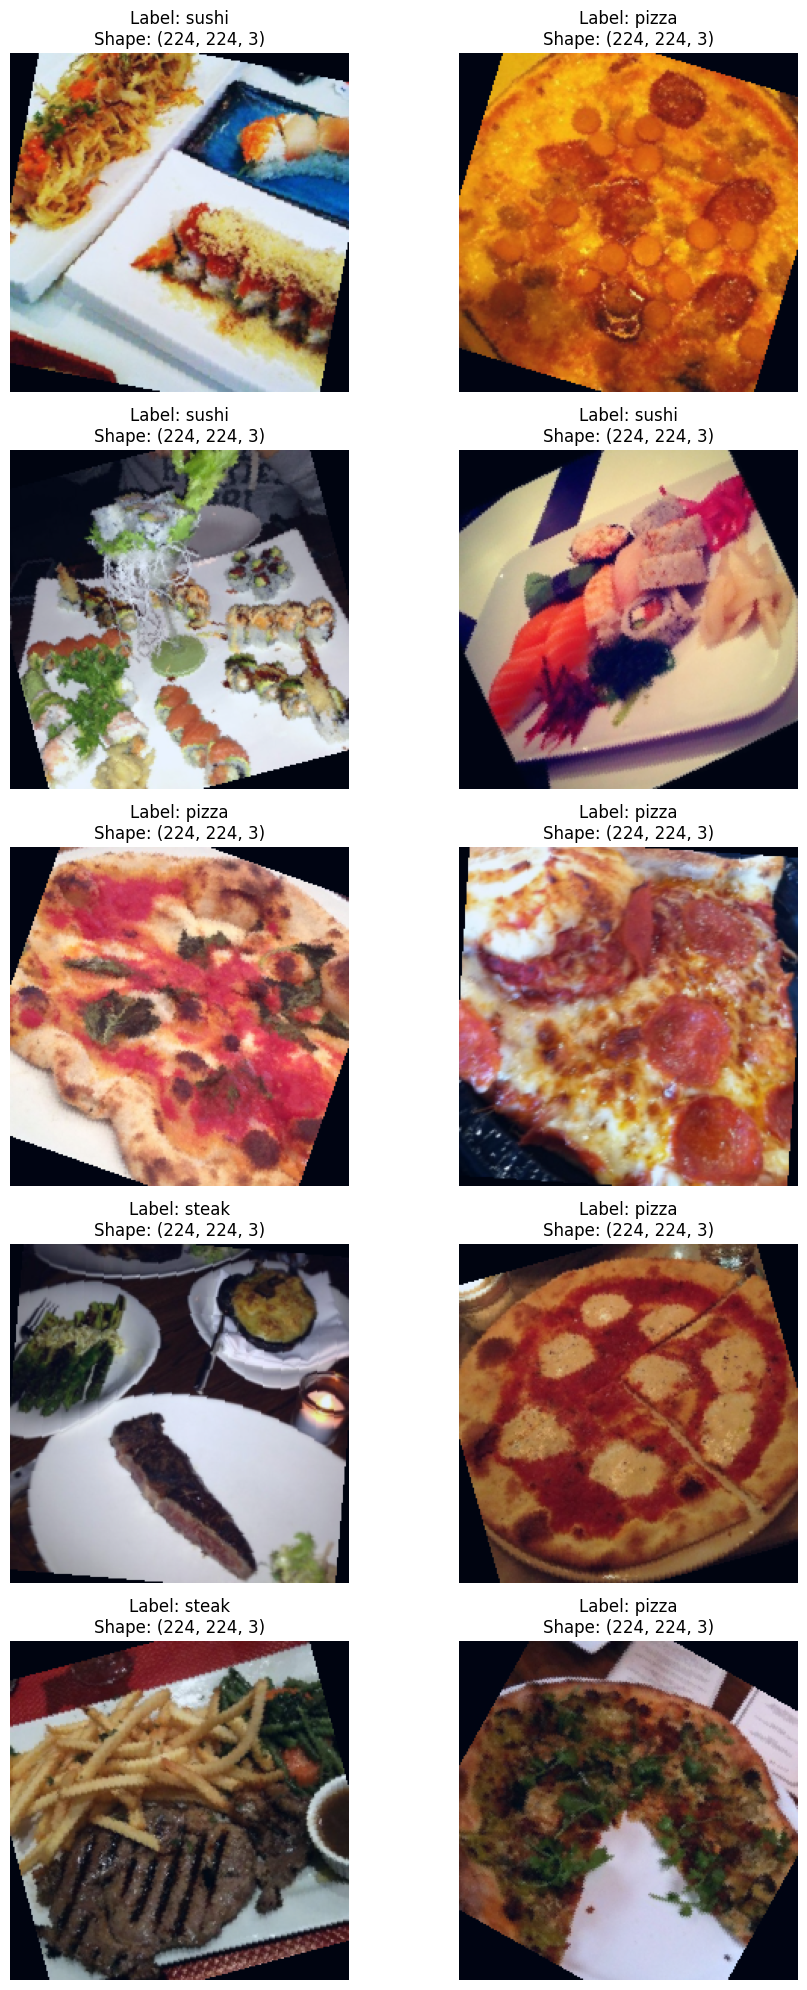

In [ ]:
# visualize the sample of train dataloader
batch_images, batch_labels = next(iter(train_dataloader))

# function for displaying 10 images randomly
def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # normalization display to 0 - 1
        ax.imshow(img)
        # get class name from label
        label_idx = labels[i].item()
        class_name = class_names[label_idx]
        # display class name
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# display images
display_images(batch_images, batch_labels, train_dataset.classes)

## **3. Build ResNet50 Model**

Next is building model stage. The model used is the pretrained ResNet 50 model, but the difference is in the transfer learning method. Here, both methods will be tried:

1. Transfer Learning: Fine-Tuning: All layers are retrained.
2. Transfer Learning: Fix Feature Extractor: Only the fully connected layer is trained.

In both methods, the fully connected layer is slightly modified, using only 1 layer with an additional Dropout = 0.3 and ReLU activation function.

### a. Fine tuning

In [ ]:
# load pretrained ResNet50 model
rn50_finetuning = resnet50(weights=ResNet50_Weights.DEFAULT)

# modify fully connected layer
rn50_finetuning.fc = nn.Sequential(nn.Dropout(0.3),
                                   nn.ReLU(),
                                   nn.Linear(in_features=rn50_finetuning.fc.in_features, out_features=len(train_dataset.classes)))

# unfreeze pretrained layers
for param in rn50_finetuning.parameters():
    param.requires_grad = True

# unfreeze fully connected layers
for param in rn50_finetuning.fc.parameters():
    param.requires_grad = True

rn50_finetuning = rn50_finetuning.to(device)

In [ ]:
# display model summary
summary(model=rn50_finetuning,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

### b. Fix feature extractor

In [ ]:
# load pretrained ResNet50 model
rn50_fixextractor = resnet50(weights=ResNet50_Weights.DEFAULT)

# modify fully connected layer
rn50_fixextractor.fc = nn.Sequential(nn.Dropout(0.3),
                                     nn.ReLU(),
                                     nn.Linear(in_features=rn50_fixextractor.fc.in_features, out_features=len(train_dataset.classes)))

# freeze pretrained layers
for param in rn50_fixextractor.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_fixextractor.fc.parameters():
    param.requires_grad = True

rn50_fixextractor = rn50_fixextractor.to(device)

In [ ]:
# display model summary
summary(model=rn50_fixextractor,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

## **4. Create Loss Function and Optimizer**

Loss function and optimizer are essential elements in both machine learning and deep learning modeling. The loss function is used to measure the difference between predicted values and actual values. The optimizer is to accelerate training convergence through the "learning rate." In this project, the loss function used is "CrossEntropyLoss" because the case involves multilabel prediction. The optimizer used is Adam because it is considered faster in achieving model convergence.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_finetuning = Adam(params=rn50_finetuning.parameters(), lr=0.001) # for fine tuning
optimizer_fixextractor = Adam(params=rn50_fixextractor.parameters(), lr=0.001) # for fix feature extractor

## **5. Create Train - Validation Loop Function**

Here are the functions for the model training process in classification cases. The evaluation metric used is accuracy.

In [ ]:
# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
# validation loop test
def val_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)

            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [ ]:
# train process

# 1. take in various parameters required for training and test steps
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # 2. create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        # 4. print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. return the filled results at the end of the epochs
    return results

## **6. Training Process**

### a. Fine tuning results

In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 100

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
finetuning_results = train_process(model=rn50_finetuning,
                                   train_dataloader=train_dataloader,
                                   val_dataloader=val_dataloader,
                                   optimizer=optimizer_finetuning,
                                   loss_fn=loss_fn,
                                   epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7675 | train_acc: 0.6836 | val_loss: 0.4923 | val_acc: 0.9271
Epoch: 2 | train_loss: 0.2549 | train_acc: 0.9453 | val_loss: 10.6893 | val_acc: 0.6562
Epoch: 3 | train_loss: 0.3365 | train_acc: 0.9414 | val_loss: 4.2586 | val_acc: 0.6146
Epoch: 4 | train_loss: 0.4112 | train_acc: 0.8164 | val_loss: 0.5461 | val_acc: 0.8229
Epoch: 5 | train_loss: 0.3610 | train_acc: 0.8164 | val_loss: 0.2420 | val_acc: 0.9375
Epoch: 6 | train_loss: 0.4742 | train_acc: 0.8047 | val_loss: 1.8405 | val_acc: 0.7509
Epoch: 7 | train_loss: 0.3969 | train_acc: 0.9219 | val_loss: 0.4704 | val_acc: 0.8239
Epoch: 8 | train_loss: 0.3863 | train_acc: 0.8125 | val_loss: 0.8719 | val_acc: 0.7027
Epoch: 9 | train_loss: 0.4019 | train_acc: 0.8203 | val_loss: 0.4327 | val_acc: 0.8362
Epoch: 10 | train_loss: 0.4275 | train_acc: 0.8164 | val_loss: 1.8842 | val_acc: 0.5985
Epoch: 11 | train_loss: 0.3011 | train_acc: 0.9023 | val_loss: 0.8718 | val_acc: 0.6828
Epoch: 12 | train_loss: 0.3693 | train_a

### b. Fix feature extractor results

In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 100

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
fixextractor_results = train_process(model=rn50_fixextractor,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     optimizer=optimizer_fixextractor,
                                     loss_fn=loss_fn,
                                     epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1029 | train_acc: 0.4102 | val_loss: 0.9846 | val_acc: 0.6307
Epoch: 2 | train_loss: 0.8998 | train_acc: 0.7852 | val_loss: 0.9147 | val_acc: 0.6203
Epoch: 3 | train_loss: 0.8238 | train_acc: 0.7930 | val_loss: 0.8586 | val_acc: 0.6818
Epoch: 4 | train_loss: 0.7592 | train_acc: 0.6914 | val_loss: 0.7834 | val_acc: 0.8049
Epoch: 5 | train_loss: 0.6910 | train_acc: 0.7969 | val_loss: 0.7462 | val_acc: 0.8049
Epoch: 6 | train_loss: 0.6212 | train_acc: 0.7734 | val_loss: 0.6889 | val_acc: 0.8968
Epoch: 7 | train_loss: 0.5669 | train_acc: 0.9023 | val_loss: 0.6458 | val_acc: 0.8968
Epoch: 8 | train_loss: 0.5677 | train_acc: 0.9297 | val_loss: 0.6531 | val_acc: 0.8561
Epoch: 9 | train_loss: 0.6258 | train_acc: 0.8047 | val_loss: 0.6161 | val_acc: 0.8362
Epoch: 10 | train_loss: 0.4915 | train_acc: 0.9336 | val_loss: 0.5336 | val_acc: 0.9176
Epoch: 11 | train_loss: 0.4580 | train_acc: 0.9141 | val_loss: 0.5364 | val_acc: 0.9176
Epoch: 12 | train_loss: 0.4965 | train_ac

## **7. Evaluate Model**

Both transfer learning methods have been trained for 100 epochs, and the results are displayed in the form of loss and accuracy curves. Here are the results:

1. The fine-tuning training result is very poor because it is fluctuating and not convergence at all.
2. The fix feature extractor training result is relatively much better, although it is still fluctuating, it is convergence sufficiently, and shows slight overfitting. The training curve fluctuates in the range of 80% to 98%, while the validation curve tends to be more stable in the range of 85% to 90%.

From these results, it is evident that the fix feature extractor transfer learning method is indeed much better than fine-tuning method. However, the training results have not yet reached perfect convergence. Several attempts have been conducted, such as adding hidden layers to the fully connected layer, adding Dropout and Activation Function, changing the optimizer and learning rate, and increasing the number of epochs, but the results remain the same. This may be due to the small dataset size, causing the model to not be able to represent the dataset patterns perfectly.

In [ ]:
# check the finetuning_results keys
finetuning_results.keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])

In [ ]:
# check the fixextractor_results keys
fixextractor_results.keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])

In [ ]:
# creat plot function for display result of training process
def plot_loss_curves(results: Dict[str, List[float]], suptitle=None):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # get the loss values of the results dictionary (training and validation)
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    # get the accuracy values of the results dictionary (training and validation)
    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    # figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # setup a plot
    plt.figure(figsize=(12, 4))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.suptitle(suptitle)

    plt.show()

### a. Fine tuning evaluation

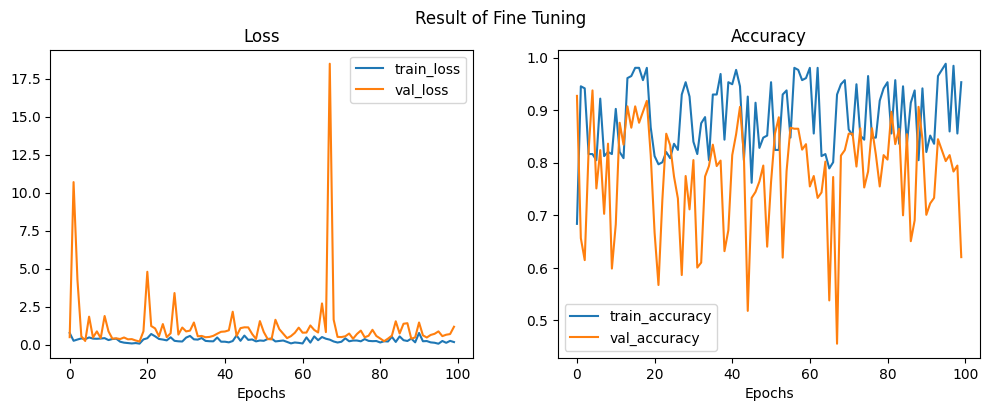

In [ ]:
# plotting loss and accuracy from fine tuning results
plot_loss_curves(finetuning_results, suptitle="Result of Fine Tuning")

### b. Fix feature extractor evaluation

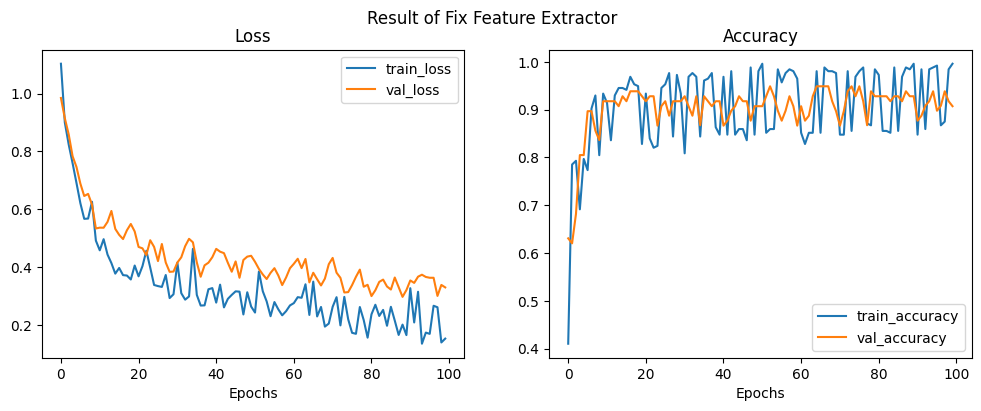

In [ ]:
# plotting loss and accuracy from fix feature extractor results
plot_loss_curves(fixextractor_results, suptitle="Result of Fix Feature Extractor")

## **8. Save The Best Model**

In [ ]:
# 1. create models directory
model_path = Path("/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "01_food_classification_pytorch_rn50.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=rn50_fixextractor.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/01_food_classification_pytorch_rn50.pth


## **9. Making Prediction**

In [ ]:
# load the saved model
model_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/01_food_classification_pytorch_rn50.pth"
model = resnet50(weights=None)
model.fc = nn.Sequential(nn.Dropout(0.3),
                         nn.ReLU(),
                         nn.Linear(in_features=2048, out_features=3))
model.load_state_dict(torch.load(model_path))
model.eval()

# define transformations for preprocessing the input image
preprocess = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# define class labels
class_labels = train_dataset.classes

# function to predict class and display image with prediction and confidence
def predict_image(image_path, model):
    # open and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # add batch dimension

    # make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        predicted_label = class_labels[predicted.item()]

    # display the image with prediction and confidence
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_label}, Confidence: {confidence[predicted.item()]:.2f}%")
    plt.axis("off")
    plt.show()

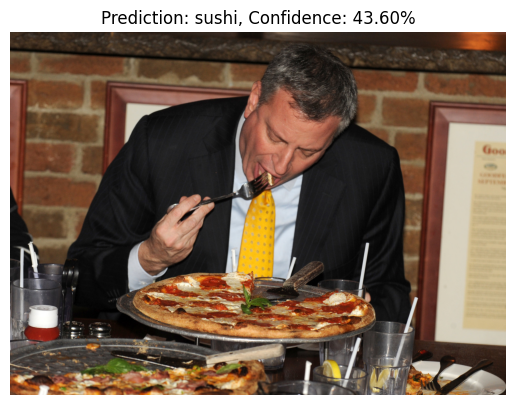

In [ ]:
# example usage
image_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/eat pizza.jpg"  # eat pizza photo
predict_image(image_path, model)

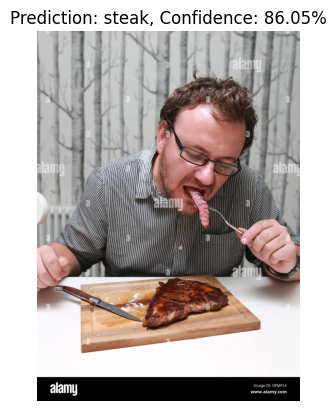

In [ ]:
# example usage
image_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/eat steak.jpg"  # eat steak photo
predict_image(image_path, model)

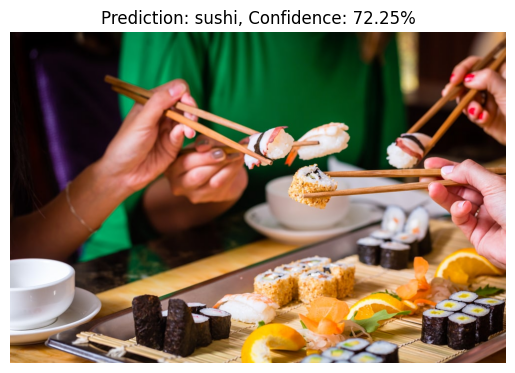

In [ ]:
# example usage
image_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/eat sushi.jpg"  # eat sushi photo
predict_image(image_path, model)

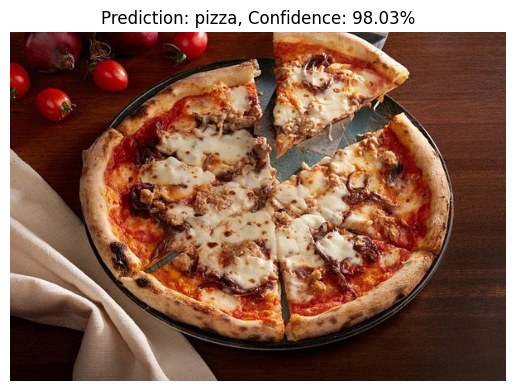

In [ ]:
# example usage
image_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/pizza.jpg"  # pizza photo
predict_image(image_path, model)

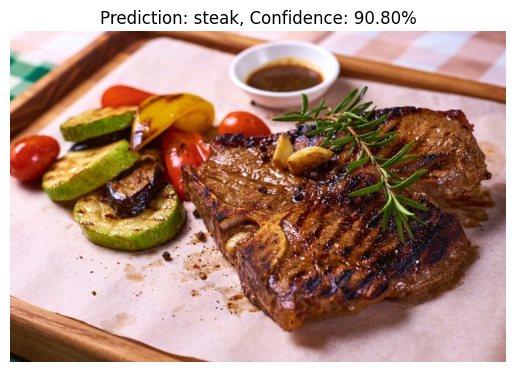

In [ ]:
# example usage
image_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/steak.jpg"  # steak photo
predict_image(image_path, model)

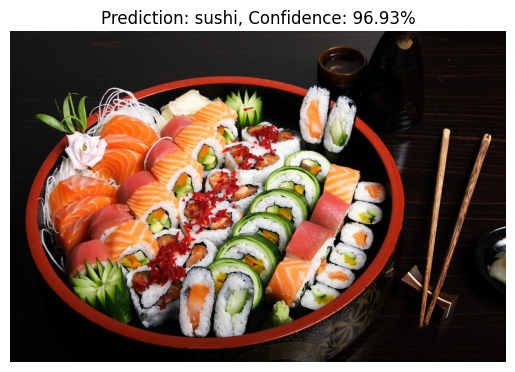

In [ ]:
# example usage
image_path = "/content/drive/MyDrive/Dataset/project_cv_2_FoodClassification/sushi.jpg"  # sushi photo
predict_image(image_path, model)

The model with the best training result (fix feature extractor method) has been saved. The saved model is then used to simulate predictions on several photos. From several simulations, there was 1 prediction error where a photo of a person eating pizza was incorrectly predicted as sushi. This may be due to the insufficient number and variety of datasets, causing the model not to recognize the photo as pizza. Thus, this experiment, this project can still be further improved with more in-depth experiments. Thank you.